In [1]:
from pyspark.sql import SparkSession

sc = SparkSession.builder \
    .appName("lesson6") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

## spark-sql 的数据关联

数据关联（Join）指的是这样一个计算过程：给定关联条件（Join Conditions）将两张数据表以不同关联形式拼接在一起的过程。关联条件包含两层含义，一层是两张表中各自关联字段（Join Key）的选择，另一层是关联字段之间的逻辑关系。是数据分析场景中最常见、最重要的操作

Join 的种类非常丰富。如果按照关联形式（Join Types）来划分，数据关联分为内关联、外关联、左关联、右关联，等等。对于参与关联计算的两张表，关联形式决定了结果集的数据来源。在开发过程中选择哪种关联形式，是由我们的业务逻辑决定的

而从实现机制的角度，Join 又可以分为 NLJ（Nested Loop Join）、SMJ（Sort Merge Join）和 HJ（Hash Join）。也就是说，同样是内关联，我们既可以采用 NLJ 来实现，也可以采用 SMJ 或是 HJ 来实现。区别在于，在不同的计算场景下，这些不同的实现机制在执行效率上有着天壤之别

### 关联形式（Join Types）
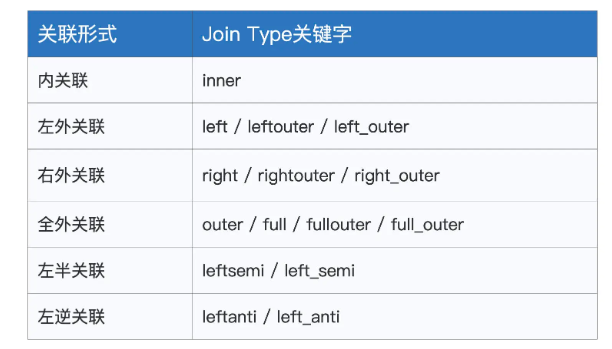

内”、“外”、“左”、“右”这些说法的含义和mysql的类似，这里不再阐述，主要介绍左半 / 逆关联（Left Semi Join / Left Anti Join）

#### 左半关联 left_semi
左半关联是内关联的一个子集；其次，它只保留左表 salaries 中的数据。这两个特点叠加在一起，很好地诠释了“左、半”这两个字。
#### 左逆关联 left_anti
左逆关联同样只保留左表的数据，它的关键字有“leftanti”和“left_anti”。但与左半关联不同的是，它保留的，是那些不满足关联条件的数据记录

### 关联机制（Join Mechanisms） 

根据业务逻辑选用适用的关联形式后，还需要选择关联的实现机制，不同的关联机制影响着我们程序的运算性能，比如同样是内关联，不同的 Join 实现机制在执行效率方面差异巨大。因此，掌握不同关联机制的实现原理与特性，有利于提高程序运行的性能

Join 有 3 种实现机制，分别是 NLJ（Nested Loop Join）、SMJ（Sort Merge Join）和 HJ（Hash Join）

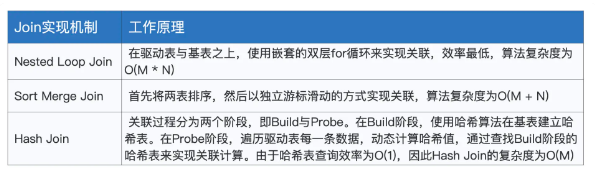

详细的算法原理可以查询相关文档，我们主要关心这三种实现机制的适用场景



三者之中，Hash Join 的执行效率最高，这主要得益于哈希表 O(1) 的查找效率。不过，在 Probe 阶段享受哈希表的“性能红利”之前，Build 阶段得先在内存中构建出哈希表才行。因此，Hash Join 这种算法对于内存的要求比较高，适用于内存能够容纳基表数据的计算场景。

Sort Merge Join 就没有内存方面的限制。不论是排序、还是合并，SMJ 都可以利用磁盘来完成计算。所以，在稳定性这方面，SMJ 更胜一筹。而且与 Hash Join 相比，SMJ 的执行效率也没有差太多，前者是 O(M)，后者是 O(M + N)，可以说是不分伯仲。当然，O(M + N) 的复杂度得益于 SMJ 的排序阶段。因此，如果准备参与 Join 的两张表是有序表，那么这个时候采用 SMJ 算法来实现关联简直是再好不过了。

与前两者相比，Nested Loop Join 看上去有些多余，嵌套的双层 for 循环带来的计算复杂度最高：O(M * N)。不过，尺有所短寸有所长，执行高效的 HJ 和 SMJ 只能用于等值关联，也就是说关联条件必须是等式，像 salaries(“id”) < employees(“id”) 这样的关联条件，HJ 和 SMJ 是无能为力的。相反，NLJ 既可以处理等值关联（Equi Join），也可以应付不等值关联（Non Equi Join），可以说是数据关联在实现机制上的最后一道防线

### 分布式环境下的 Join 策略

在分布式环境中，两张表的数据各自散落在不同的计算节点与 Executors 进程。因此，要想完成数据关联，Spark SQL 就必须先要把 Join Keys 相同的数据，分发到同一个 Executors 中去才行

